# Read .mat in a folder

In [2]:
import sys
import numpy as np 
import nemaktis as nm 
from scipy.io import loadmat
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [3]:
#path_directors = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/POUYA/director_clean/'
# path_directors = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/efficient_dir/'
# path_directors = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/checkpoints/'
path_directors = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/results/'

In [4]:
#path_directors = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/POUYA/director_clean/'

# Read u, v, w with usual Pouya format
i = 0
for root, dirs, files in os.walk(path_directors):
    for file_name in files:
        full_path = os.path.join(root, file_name)
        #print(full_path)
        if ('.mat' in file_name): 
            print(file_name)
            name_director = file_name 
            data = loadmat(path_directors+name_director)
            # u_matlab = data['u_final']  # (3,80,10)
            # v_matlab = data['v_final']
            # w_matlab = data['w_final']    
            print(data.keys())
            #print(u_matlab.shape)
            break 
        

checkpoint_justforthe equations_iter1000.mat
dict_keys(['__header__', '__version__', '__globals__', 'Q11_matrix', 'Q12_matrix', 'Q13_matrix', 'Q22_matrix', 'Q23_matrix', 'alpha', 'iter'])


# Read VTK / VTI 

In [4]:
import pyvista as pv

mesh = pv.read("./VTK/test01.vtk")
print(mesh['vector_field'])
print(mesh)
print(mesh.dimensions)

[[ 0.00137073 -0.99999905  0.        ]
 [ 0.00137073 -0.99999905  0.        ]
 [ 0.00137073 -0.99999905  0.        ]
 ...
 [ 0.99999803 -0.00198171  0.        ]
 [ 0.99999803 -0.00198171  0.        ]
 [ 0.99999803 -0.00198171  0.        ]]
StructuredGrid (0x1882c33df40)
  N Cells:      28899
  N Points:     32000
  X Bounds:     -1.950e+01, 1.950e+01
  Y Bounds:     -1.950e+01, 1.950e+01
  Z Bounds:     -9.500e+00, 9.500e+00
  Dimensions:   40, 40, 20
  N Arrays:     3
(40, 40, 20)


In [30]:
mesh["n"] = mesh["vector_field"]

In [31]:
mesh

StructuredGrid (0x17aa548c640)
  N Cells:      28899
  N Points:     32000
  X Bounds:     -1.950e+01, 1.950e+01
  Y Bounds:     -1.950e+01, 1.950e+01
  Z Bounds:     -9.500e+00, 9.500e+00
  Dimensions:   40, 40, 20
  N Arrays:     4

In [32]:
mesh.save("./VTK/GM_test01.vtk")

In [33]:
print(type(mesh), mesh)  

<class 'pyvista.core.pointset.StructuredGrid'> StructuredGrid (0x17aa548c640)
  N Cells:      28899
  N Points:     32000
  X Bounds:     -1.950e+01, 1.950e+01
  Y Bounds:     -1.950e+01, 1.950e+01
  Z Bounds:     -9.500e+00, 9.500e+00
  Dimensions:   40, 40, 20
  N Arrays:     4


## Converter vtk to vti 

In [5]:

import numpy as np
import pyvista as pv

# 1) Load your structured grid
src = pv.read("./VTK/GM_test01.vtk")  # your .vtk file
print(type(src), src)

# Sanity check
assert isinstance(src, pv.StructuredGrid), "The input must be a StructuredGrid."

# 2) Decide target dimensions (match the original)
nx, ny, nz = src.dimensions  # (40, 40, 20)

# 3) Build an ImageData with same bounds and matching resolution
xmin, xmax, ymin, ymax, zmin, zmax = src.bounds

# spacing so that we have nx,ny,nz points across bounds
dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dz = (zmax - zmin) / (nz - 1)

img = pv.ImageData()
img.origin     = (xmin, ymin, zmin)
img.spacing    = (dx, dy, dz)
img.dimensions = (nx, ny, nz)   # points along each axis

# 4) If your arrays are cell-centered and you want point-centered interpolation, convert:
# (Safe even if there's no cell data)
src_for_sampling = src
# src_for_sampling = src.cell_data_to_point_data(copy=False)

# 5) Resample all arrays from the structured grid onto the uniform image grid
img_resampled = img.sample(src_for_sampling)  # alias: img.resample(src_for_sampling)

# 6) Save as .vti
img_resampled.save("./VTK/output.vti")

# 7) Verify
out = pv.read("output.vti")
print("Output type:", type(out))
print("Dimensions:", out.dimensions)
print("Spacing:", out.spacing)
print("Origin:", out.origin)
print("Point arrays:", list(out.point_data.keys()))
print("Cell arrays:",  list(out.cell_data.keys()))


<class 'pyvista.core.pointset.StructuredGrid'> StructuredGrid (0x1883d571160)
  N Cells:      28899
  N Points:     32000
  X Bounds:     -1.950e+01, 1.950e+01
  Y Bounds:     -1.950e+01, 1.950e+01
  Z Bounds:     -9.500e+00, 9.500e+00
  Dimensions:   40, 40, 20
  N Arrays:     4
Output type: <class 'pyvista.core.grid.ImageData'>
Dimensions: (40, 40, 20)
Spacing: (1.0, 1.0, 1.0)
Origin: (-19.5, -19.5, -9.5)
Point arrays: ['IsLC', 'S', 'n', 'vector_field', 'vtkValidPointMask', 'vtkGhostType']
Cell arrays: ['vtkGhostType']


In [6]:
def transform_vtk_vti(input_vtk,output_vti):
    '''Insert the complete path of the vtk file and the complete path of the vti file that you want to save. 
     If you are working in the same directory you can just pass the name of the image.'''
    import numpy as np
    import pyvista as pv
    
    # 1) Load your structured grid
    src = pv.read(input_vtk)  # your .vtk file
    print(type(src), src)
    
    # Sanity check
    assert isinstance(src, pv.StructuredGrid), "The input must be a StructuredGrid."
    
    # 2) Decide target dimensions (match the original)
    nx, ny, nz = src.dimensions  # (40, 40, 20)
    
    # 3) Build an ImageData with same bounds and matching resolution
    xmin, xmax, ymin, ymax, zmin, zmax = src.bounds
    
    # spacing so that we have nx,ny,nz points across bounds
    dx = (xmax - xmin) / (nx - 1)
    dy = (ymax - ymin) / (ny - 1)
    dz = (zmax - zmin) / (nz - 1)
    
    img = pv.ImageData()
    img.origin     = (xmin, ymin, zmin)
    img.spacing    = (dx, dy, dz)
    img.dimensions = (nx, ny, nz)   # points along each axis
    
    # 4) If your arrays are cell-centered and you want point-centered interpolation, convert:
    # (Safe even if there's no cell data)
    src_for_sampling = src
    # src_for_sampling = src.cell_data_to_point_data(copy=False)
    
    # 5) Resample all arrays from the structured grid onto the uniform image grid
    img_resampled = img.sample(src_for_sampling)  # alias: img.resample(src_for_sampling)
    
    # 6) Save as .vti
    # save the director as a vector named "n" as required by Nemaktis
    img_resampled['n'] = img_resampled['vector_field']
    img_resampled.save(output_vti)
    
    # 7) Verify
    out = pv.read(output_vti)
    print("Output type:", type(out))
    print("Dimensions:", out.dimensions)
    print("Spacing:", out.spacing)
    print("Origin:", out.origin)
    print("Point arrays:", list(out.point_data.keys()))
    print("Cell arrays:",  list(out.cell_data.keys()))


In [7]:
#transform_vtk_vti(input_vtk="./VTK/Excitation02.vtk",output_vti="./VTK/Excitation02.vti")
#transform_vtk_vti(input_vtk="./VTK/Excitation02_twist.vtk",output_vti="./VTK/Excitation02_twist.vti")
#transform_vtk_vti(input_vtk="./VTK/Directorfield_sinxy_400.vtk",output_vti="./VTK/Directorfield_sinxy_400.vti")

transform_vtk_vti(input_vtk="./VTK/Directorfield_sinxy_300_theta90v.vtk",output_vti="./VTK/Directorfield_sinxy_300_theta90v__.vti")


<class 'pyvista.core.pointset.StructuredGrid'> StructuredGrid (0x1883d589460)
  N Cells:      5811065
  N Points:     5940000
  X Bounds:     0.000e+00, 2.990e+02
  Y Bounds:     0.000e+00, 2.990e+02
  Z Bounds:     0.000e+00, 2.300e+01
  Dimensions:   300, 300, 66
  N Arrays:     0


KeyError: 'Data array (vector_field) not present in this dataset.'

In [42]:
plt.hist(img_resampled['n'])
plt.show()

In [43]:
print(img_resampled)

ImageData (0x17aa548c100)
  N Cells:      28899
  N Points:     32000
  X Bounds:     -1.950e+01, 1.950e+01
  Y Bounds:     -1.950e+01, 1.950e+01
  Z Bounds:     -9.500e+00, 9.500e+00
  Dimensions:   40, 40, 20
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     7


C:\Users\manzoni\Miniforge3\envs\nm\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


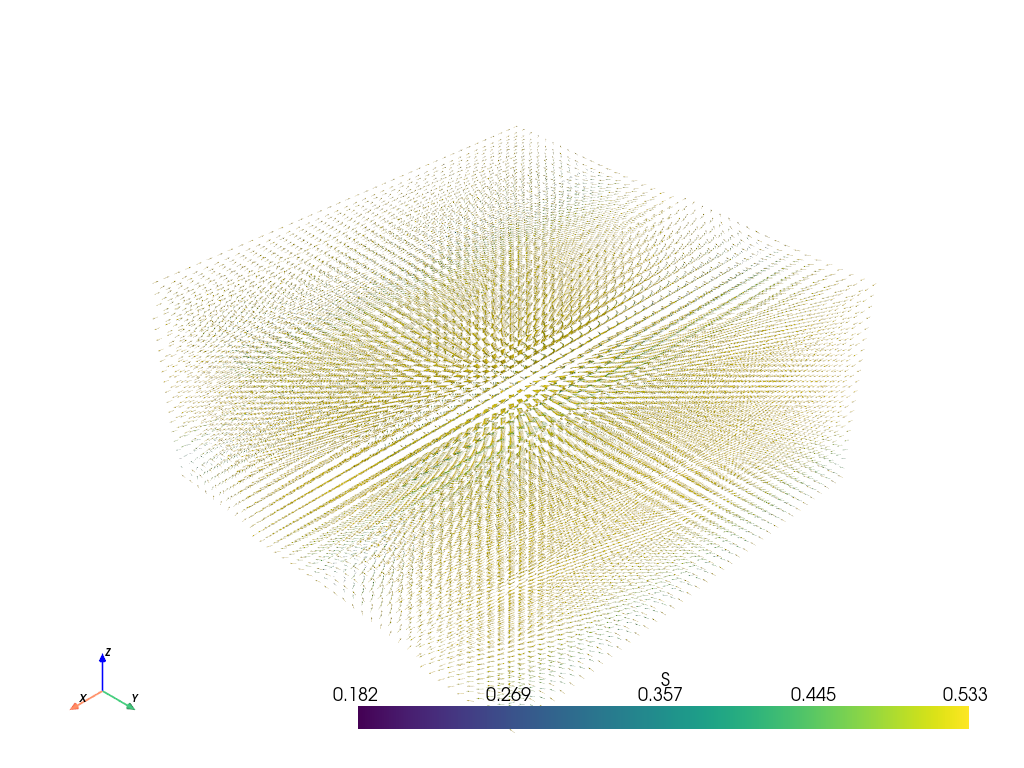

In [54]:
# img_resampled.plot()
img_resampled.set_active_vectors("vector_field")
arrows = img_resampled.glyph(orient="vector_field",scale="S", factor=1.0)
arrows.plot()


C:\Users\manzoni\Miniforge3\envs\nm\lib\site-packages\pyvista\core\filters\data_set.py:3066: PyVistaDeprecationWarning: ``max_time`` parameter is deprecated.  It will be removed in v0.48
  warnings.warn(
C:\Users\manzoni\Miniforge3\envs\nm\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


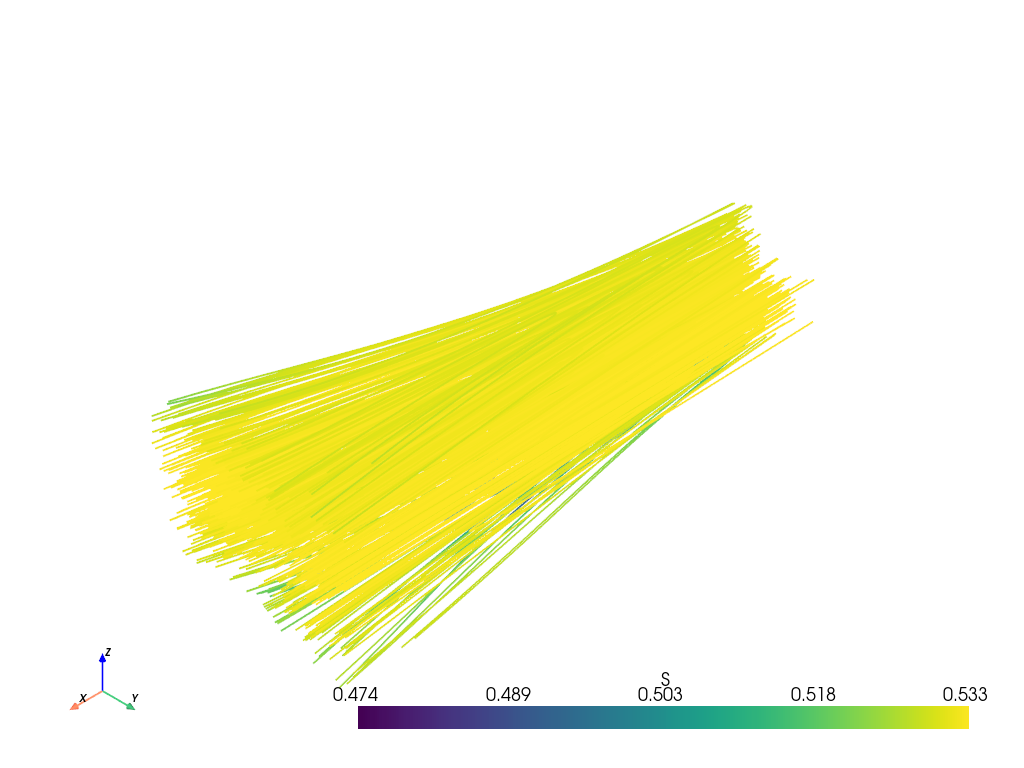

In [55]:

stream = img_resampled.streamlines(
    n_points=500,          # seed points
    max_time=200.0,        # how long each streamline runs
    terminal_speed=1e-12,  # stop condition
)

stream.plot(line_width=2)


# H5 files

In [15]:
# Try to read from different matlab format
import h5py 
filename = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/efficient_dir/Qtensor_final.mat'          
data = h5py.File(filename)
print(data.keys())
print(data['nx'][0].shape)


# u_matlab = data['u_final']  # (3,80,10)
# v_matlab = data['v_final']
# w_matlab = data['w_final']    
# print(u_matlab.shape)

        

<KeysViewHDF5 ['Q11', 'Q12', 'Q13', 'Q22', 'Q23', 'nx', 'ny', 'nz']>
(1000, 1000)


In [19]:
filename_p = 'C:/Users/manzoni/Desktop/SKL/NEMAKTIS/POUYA/director_clean/QTensor_director_solution-K11_1.01e-11-K22_6.5e-12-K33_1.7e-11-K24_4e-12.mat'
data_p = loadmat(filename_p)

data_p.keys()

data_p['u_final'][0].shape

(80, 10)